# Training a causal language model from scratch

We’ll train a completely new model from **scratch**. This is a good approach to take if you have a **lot of data** and it is **very different from the pretraining data used for the available models**. However, it also requires considerably more compute resources to pretrain a language model than just to **fine-tune an existing one**. Examples where it can make sense to train a new model include for datasets consisting of musical notes, molecular sequences such as DNA, or programming languages. This task of text generation is best addressed with auto-regressive or causal language models such as GPT-2.

In this section we will build a scaled-down version of a code generation model: we’ll focus on one-line completions instead of full functions or classes, using a subset of Python code. When working with data in Python you are in frequent contact with the Python data science stack, consisting of the matplotlib, seaborn, pandas, and scikit-learn libraries. When using those frameworks it’s common to need to look up specific commands, so it would be nice if we could use a model to complete these calls for us.

# Gathering the data

Python code is abundantly available from code repositories such as GitHub, which we can use to create a dataset by scraping for every Python repository. This was the approach taken in the [Transformers textbook](https://learning.oreilly.com/library/view/natural-language-processing/9781098136789/) to pretrain a large GPT-2 model. Using a GitHub dump of about 180 GB containing roughly 20 million Python files called `codeparrot`, the authors built a dataset that they then shared on the [Hugging Face Hub](https://huggingface.co/datasets/transformersbook/codeparrot).

However, training on the full corpus is time- and compute-consuming, and we only need the subset of the dataset concerned with the Python data science stack. So, let’s start by **filtering the `codeparrot` dataset** for all files that include any of the libraries in this stack. Because of the dataset’s size, we want to **avoid downloading** it; instead, we’ll use the **streaming feature to filter it on the fly**. To help us filter the code samples using the libraries we mentioned earlier, we’ll use the following function:

## Filtering the data

In [1]:
def any_keyword_in_string(string: str, keywords: list[str]) -> bool:
    """
    Check if any of the keywords are in the string

    Parameters:
        string (str): The string to check
        keywords (list[str]): The keywords to check for

    Returns:
        bool: True if any of the keywords are in the string, False otherwise
    """
    for keyword in keywords:
        if keyword in string:
            return True
    return False

Let’s test it on two examples:

In [2]:
filters = ["pandas", "sklearn", "matplotlib", "seaborn"]
example_1 = "import numpy as np"
example_2 = "import pandas as pd"

print(
    any_keyword_in_string(example_1, filters),
    any_keyword_in_string(example_2, filters)
)

False True


We can use this to create a function that will stream the dataset and **filter the elements we want**:

In [3]:
from collections import defaultdict
from tqdm import tqdm
from datasets import Dataset

In [4]:
def filter_streaming_dataset(dataset, filters, max_samples=30000):
    """
    Filter a streaming dataset

    Parameters:
        dataset (Dataset): The streaming dataset to filter
        filters (list[str]): The keywords to filter the dataset on
        max (int): The maximum number of samples to filter

    Returns:
        Dataset: The filtered dataset

    Notes
        - Filtering the full dataset can take 2-3h depending on your
        machine and bandwidth.
    """
    filtered_dict = defaultdict(list)  # dict of lists
    total = 0  # Counting the total number of samples
    total_filtered = 0  # Counting the number of ok samples
    for sample in tqdm(iter(dataset)):  # Iterating over the dataset
        total += 1  # Incrementing the total count
        # Check if any of the filters are in the content
        if any_keyword_in_string(sample["content"], filters):
            # If so, append the sample to the filtered_dict
            for k, v in sample.items():  # Iterate over the key-value pairs
                filtered_dict[k].append(v)  # Append the data from sample
            total_filtered += 1
        # If we have filtered enough samples, break the loop
        if max_samples!=-1 and total_filtered >= max_samples:
            break

    # Print the percentage of data that is kept after filtering
    print(f"{len(filtered_dict['content'])/total:.2%} of data after filtering.")
    # Return a new Dataset from the filtered_dict
    return Dataset.from_dict(filtered_dict)

Then we can simply apply this function to the streaming dataset:

In [5]:
# This cell will take a very long time to execute, so you should skip it and go to
# the next one!
from datasets import load_dataset

split = "train"  # "valid"
filters = ["pandas", "sklearn", "matplotlib", "seaborn"]

data = load_dataset(
    f"transformersbook/codeparrot-{split}",
    split=split,
    streaming=True
)
filtered_data = filter_streaming_dataset(data, filters)

Repo card metadata block was not found. Setting CardData to empty.


Resolving data files:   0%|          | 0/183 [00:00<?, ?it/s]

927887it [09:34, 1615.81it/s]


3.23% of data after filtering.


If we set `max_samples` to "all" (-1), this leaves us with about 3% of the original dataset, which is still quite sizable — the resulting dataset is 6 GB and consists of **600,000 Python scripts**!

> Pretraining the language model will take a while. We suggest that you first run the training loop on a sample of the data by uncommenting the two partial lines above, and make sure that the training successfully completes and the models are stored. Nothing is more frustrating than a training run failing at the last step because you forgot to create a folder or because there’s a typo at the end of the training loop!

## Train and validation splits

In [6]:
raw_datasets = filtered_data.train_test_split(test_size=0.1)
# rename "test" partition to "valid"
raw_datasets['valid'] = raw_datasets.pop('test')
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['repo_name', 'path', 'copies', 'size', 'content', 'license'],
        num_rows: 27000
    })
    valid: Dataset({
        features: ['repo_name', 'path', 'copies', 'size', 'content', 'license'],
        num_rows: 3000
    })
})

Let’s look at an example from the dataset. We’ll just show the first 200 characters of each field:

In [7]:
for key in raw_datasets["train"][0]:
    print(f"{key.upper()}: {raw_datasets['train'][0][key][:200]}")

REPO_NAME: xunyou/vincent
PATH: examples/area_chart_examples.py
COPIES: 11
SIZE: 1947
CONTENT: # -*- coding: utf-8 -*-
"""

Vincent Area Examples

"""

#Build an Area Chart from scratch

from vincent import *
import pandas.io.data as web
all_data = {}
for ticker in ['AAPL', 'GOOG', 'IBM', 'YHOO
LICENSE: mit


We can see that the content field contains the code that we want our model to train on. Now that we have a dataset, we need to prepare the texts so they’re in a format suitable for pretraining.

## Tokenization

The first step will be to **tokenize the data**, so we can use it for training. Since our goal is to mainly autocomplete short function calls, we can keep the **context size relatively small**. This has the benefit that we can train the model much faster and it requires significantly less memory. If it is important for your application **to have more context** (for example, if you want the model to write unit tests based on a file with the function definition), make sure you increase that number, but also keep in mind that this comes with a greater GPU memory footprint. For now, let’s fix the context size at 128 tokens, as opposed to the 1,024 or 2,048 used in GPT-2 or GPT-3, respectively.

Most documents contain many more than 128 tokens, so simply **truncating the inputs to the maximum length** would eliminate a large fraction of our dataset. Instead, we’ll use the `return_overflowing_tokens` option to tokenize the whole input and **split it into several chunks**. We’ll also use the `return_length` option to return the length of each created chunk automatically. Often the last chunk will be smaller than the context size, and we’ll get rid of these pieces to avoid padding issues; we don’t really need them as we have plenty of data anyway.

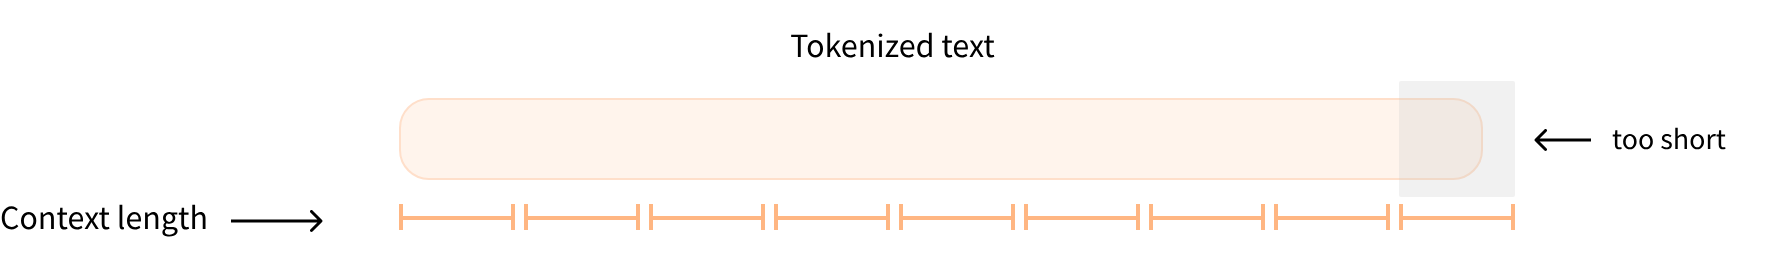

In [8]:
from transformers import AutoTokenizer

context_length = 128
tokenizer = AutoTokenizer.from_pretrained(
    "huggingface-course/code-search-net-tokenizer"
)

outputs = tokenizer(
    raw_datasets["train"][:2]["content"],  # use two samples
    truncation=True,
    max_length=context_length,
    return_overflowing_tokens=True,
    return_length=True,
)

print(f"Input IDs length (number of chunks): {len(outputs['input_ids'])}")
print(f"Input chunk lengths: {(outputs['length'])}")
print(f"Chunk mapping: {outputs['overflow_to_sample_mapping']}")

Input IDs length (number of chunks): 20
Input chunk lengths: [128, 128, 128, 128, 73, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 17]
Chunk mapping: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


We can see that we get 31 segments in total from those two examples. Looking at the chunk lengths, we can see that the chunks at the ends of both documents have less than 128 tokens (110 and 12, respectively). These represent just a small fraction of the total chunks that we have, so we can **safely throw them away**. With the `overflow_to_sample_mapping` field, we can also reconstruct which chunks belonged to which input samples.

With this operation we’re using a handy feature of the `Dataset.map()` function in Hugging Face Datasets, which is that it does not require one-to-one maps; we can create batches with more or fewer elements than the input batch. This is useful when doing operations like data augmentation or data filtering that change the number of elements. In our case, when tokenizing each element into chunks of the specified context size, we create many samples from each document. We just need to make sure to delete the existing columns, since they have a conflicting size. If we wanted to keep them, we could repeat them appropriately and return them within the `Dataset.map()` call.

> Getting rid of all the chunks that are smaller than the context size wasn’t a big issue here because we’re using small context windows. As you increase the context size (or if you have a corpus of short documents), the fraction of chunks that are thrown away will also grow. A more efficient way to prepare the data is to **join all the tokenized samples** in a batch with an `eos_token_id` token in between, and then perform the chunking on the concatenated sequences. Note that you’ll want to set **truncation=False** and remove the other arguments from the tokenizer to get the full sequence of token IDs.

In [9]:
def tokenize(elements):
    """
    Tokenize the content of the elements throwing away the overflowing tokens
    """
    outputs = tokenizer(  # Tokenize the samples to input_ids
        elements["content"],
        truncation=True,  # Truncate the content
        max_length=context_length,  # Set the maximum length per chunk
        return_overflowing_tokens=True,  # Don't discard overflowing tokens
        return_length=True,  # Return the length of each chunk
    )

    input_batch = []
    # Iterate over each chunk and its length
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        # Discard chunks that are not chunk_length
        if length == context_length:
            input_batch.append(input_ids)

    return {"input_ids": input_batch}

In [10]:
def tokenize_joining(elements):
    outputs = tokenizer(
        elements["content"],
        truncation=False
    )

    all_input_ids = []
    for iid in outputs["input_ids"]:
        all_input_ids.extend(iid + [tokenizer.eos_token_id])

    # We drop the last chunk if it's smaller than chunk_size
    total_length = len(all_input_ids)
    total_length = (total_length // context_length) * context_length

    chunks = []
    for i in range(0, total_length, context_length):
        chunks.append(all_input_ids[i:i + context_length])

    return {"input_ids": chunks}

In [11]:
tokenized_datasets = raw_datasets.map(
    tokenize_joining,
    batched=True,
    # Remove columns that are not used
    remove_columns=raw_datasets["train"].column_names
)
tokenized_datasets

Map:   0%|          | 0/27000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1809 > 1024). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 759667
    })
    valid: Dataset({
        features: ['input_ids'],
        num_rows: 84454
    })
})

In [12]:
# Count the number of tokens in the dataset
total_tokens = tokenized_datasets["train"].num_rows * context_length
# display the number of tokens in billions
total_tokens

97237376

We now have 25.4 million examples with 128 tokens each, which corresponds to about 32 million tokens in total. For reference, OpenAI’s GPT-3 and Codex models are trained on 300 and 100 billion tokens, respectively, where the Codex models are initialized from the GPT-3 checkpoints. Our goal in this section is not to compete with these models, which can generate long, coherent texts, but to create a scaled-down version providing a quick autocomplete function for data scientists.

Now that we have the dataset ready, let’s set up the model!

# Initializing a new model

Our first step is to freshly initialize a GPT-2 model. We’ll use the same configuration for our model as for the small GPT-2 model, so we load the pretrained configuration, make sure that the tokenizer size matches the model vocabulary size and pass the `bos` and `eos` (beginning and end of sequence) token IDs:

In [ ]:
from transformers import AutoTokenizer, GPT2LMHeadModel, AutoConfig

config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=context_length,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

With that configuration, we can load a new model. Note that this is the first time **we don’t use the `from_pretrained()`** function, since we’re actually initializing a model ourself:

In [14]:
model = GPT2LMHeadModel(config)
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

GPT-2 size: 124.2M parameters


# Data Collator

Our model has 124M parameters that we’ll have to tune. Before we can start training, we need to set up a data collator that will take care of creating the batches. We can use the `DataCollatorForLanguageModeling` collator, which is designed specifically for **language modeling** (as the name subtly suggests). Besides stacking and padding batches, it also takes care of creating the language model labels — in causal language modeling the **inputs serve as labels too (just shifted by one element)**, and this data collator creates them on the fly during training so we don’t need to duplicate the input_ids.

> Note that `DataCollatorForLanguageModeling` supports both masked language modeling (MLM) and causal language modeling (CLM). By default it prepares data for MLM, but we can switch to CLM by setting the argument `mlm=False`:

In [15]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

Let’s have a look at an example:

In [16]:
out = data_collator([tokenized_datasets["train"][i] for i in range(5)])
for key in out:
    print(f"{key} shape: {out[key].shape}")

input_ids shape: torch.Size([5, 128])
attention_mask shape: torch.Size([5, 128])
labels shape: torch.Size([5, 128])


We can see that the examples have been stacked and all the tensors have the same shape. **Notice next that the inputs and labels are the same, they are not shifted!**

In [17]:
# Display first example, first token input id and label
out["input_ids"][0][0], out["labels"][0][0]

(tensor(3), tensor(3))

> ⚠️ **Shifting the inputs and labels to align them happens inside the model, so the data collator just copies the inputs to create the labels.**

# Trainer

All that’s left to do is configure the training arguments and fire up the Trainer. We’ll use a cosine learning rate schedule with some warmup and an effective batch size of 256 (`per_device_train_batch_size` * `gradient_accumulation_steps`). Gradient accumulation is used when a single batch does not fit into memory, and incrementally builds up the gradient through several forward/backward passes.

In [18]:
from transformers import Trainer, TrainingArguments

output_dir = f"tmp/clm-codeparrot_ds-{context_length}"

args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="steps",
    eval_steps=5_000,
    logging_steps=5_000,
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    weight_decay=0.1,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=5_000,
    fp16=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
)

Now we can just start the Trainer and wait for training to finish.

In [19]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: marioparreno. Use `wandb login --relogin` to force relogin


  0%|          | 0/5935 [00:00<?, ?it/s]

{'loss': 2.7612, 'grad_norm': 0.5376766324043274, 'learning_rate': 4.299309564517404e-05, 'epoch': 0.84}


  0%|          | 0/5279 [00:00<?, ?it/s]

{'eval_loss': 1.8816652297973633, 'eval_runtime': 204.8242, 'eval_samples_per_second': 412.324, 'eval_steps_per_second': 25.773, 'epoch': 0.84}
{'train_runtime': 5426.9103, 'train_samples_per_second': 139.981, 'train_steps_per_second': 1.094, 'train_loss': 2.622534117983888, 'epoch': 1.0}


TrainOutput(global_step=5935, training_loss=2.622534117983888, metrics={'train_runtime': 5426.9103, 'train_samples_per_second': 139.981, 'train_steps_per_second': 1.094, 'total_flos': 4.9623733518336e+16, 'train_loss': 2.622534117983888, 'epoch': 1.0})

# Code generation with a pipeline

Now is the moment of truth: let’s see how well the trained model actually works! We can see in the logs that the loss went down steadily, but to put the model to the test let’s take a look at how well it works on some prompts. To do that we’ll wrap the model in a text generation pipeline, and we’ll put it on the GPU for fast generations if there is one available:

In [22]:
import torch
from transformers import pipeline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
pipe = pipeline(
    "text-generation",
    model=output_dir + '/checkpoint-1996',
    device=device
)

In [29]:
txt = """\
# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create scatter plot with x, y
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create scatter plot with x, y
Z = plt.scatter(xx[:, 0], yy[:, 1


In [47]:
txt = """\
# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create dataframe from x and y
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create dataframe from x and y
y = x.reshape((-1, 1))
x1 =


Looking at these few examples, it seems that the model has learned some of the syntax of the Python data science stack (of course, we would need to evaluate it more thoroughly before deploying the model in the real world). Sometimes it requires more customization of the model training to achieve the necessary performance for a given use case, however. For example, what if we would like to dynamically update the batch size or have a conditional training loop that skips bad examples on the fly? One option would be to subclass the Trainer and add the necessary changes, but sometimes it’s simpler to write the training loop from scratch. Check the [Accelerate Notebook](pt_causal_scratch.ipynb).